In [1]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile, kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [2]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

### Cleaning the Data

In [3]:
df = pd.read_csv(path/'train.csv')


In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [6]:
df.fillna(modes, inplace=True)

In [7]:
print(df)

     PassengerId  Survived  Pclass                                               Name     Sex   Age  SibSp  Parch            Ticket  \
0              1         0       3                            Braund, Mr. Owen Harris    male  22.0      1      0         A/5 21171   
1              2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1      0          PC 17599   
2              3         1       3                             Heikkinen, Miss. Laina  female  26.0      0      0  STON/O2. 3101282   
3              4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1      0            113803   
4              5         0       3                           Allen, Mr. William Henry    male  35.0      0      0            373450   
..           ...       ...     ...                                                ...     ...   ...    ...    ...               ...   
886          887         0       2                     

In [8]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [9]:
import numpy as np

df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<AxesSubplot:>

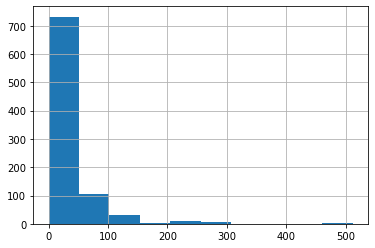

In [10]:
df['Fare'].hist()

In [11]:
# To fix this, the most common approach is to take the logarithm, which squishes the big numbers and makes the distribution more reasonable.
# Note, however, that there are zeros in the Fare column, and log(0) is infinite -- to fix this, we'll simply add 1 to all values first:
df['LogFare'] = np.log(df['Fare']+1)

<AxesSubplot:>

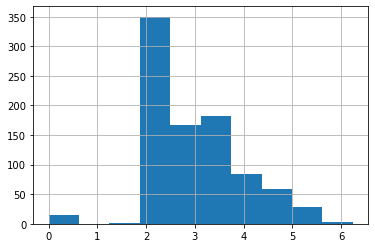

In [12]:
df['LogFare'].hist()

In [13]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [14]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Andersson, Miss. Erna Alexandra",male,347082,B96 B98,S
freq,1,577,7,691,646


In [15]:
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [16]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


In [17]:
from torch import tensor

t_dep = tensor(df.Survived)

In [18]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [19]:
t_indep.shape

torch.Size([891, 12])

#### Setting up a linear model

In [20]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [21]:
t_indep*coeffs


tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

In [22]:
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals

In [23]:
t_indep*coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [24]:
t_indep = t_indep / vals

In [25]:
preds = (t_indep*coeffs).sum(axis=1)

In [26]:
preds[:10]

tensor([ 0.3675, -0.2917,  0.3131,  0.5119,  0.3638,  0.2121,  0.5599,  0.3742,  0.3246, -0.4591])

In [27]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5415)

In [28]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

#### Doing a gradient descent step


In [29]:
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [30]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5415, grad_fn=<MeanBackward0>)

In [31]:
loss.backward()

In [32]:
coeffs.grad

tensor([ 0.0003,  0.0018, -0.0005, -0.0034,  0.2548, -0.1908, -0.1212, -0.0067,  0.1919, -0.1886,  0.0191,  0.2334])

In [33]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([ 0.0007,  0.0036, -0.0010, -0.0069,  0.5095, -0.3816, -0.2424, -0.0135,  0.3838, -0.3771,  0.0382,  0.4669])

In [34]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()

with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.4685)


1. with torch.no_grad():
This context manager temporarily disables gradient tracking in PyTorch.
Normally, PyTorch tracks all operations on tensors that require gradients to compute derivatives during backpropagation. However, certain operations (like updating parameters manually) should not be tracked.
By using torch.no_grad(), the code inside the block is executed without PyTorch tracking these operations for gradient computation.
2. coeffs.sub_(coeffs.grad * 0.1)
This line updates the coeffs tensor by subtracting a fraction of its gradient.
coeffs.grad contains the gradient of some loss function with respect to the coeffs tensor, computed in a previous step.
coeffs.grad * 0.1 scales the gradient by a learning rate of 0.1.
The sub_() method subtracts the scaled gradient from coeffs in place (the underscore _ at the end of sub_ indicates an in-place operation, modifying the tensor directly).
This step simulates a gradient descent step, where the parameters (coeffs) are adjusted to minimize the loss function.

3. coeffs.grad.zero_()
After updating the parameters, this line clears the gradients stored in coeffs.grad by setting them to zero.
This is crucial because in PyTorch, gradients are accumulated by default (i.e., if you don’t clear them, the next time gradients are computed, they will be added to the existing ones). By zeroing them out, the code ensures that the next gradient computation starts fresh.
4. print(calc_loss(coeffs, t_indep, t_dep))
This line computes and prints the loss after the parameter update.
calc_loss(coeffs, t_indep, t_dep) is presumably a function that calculates the loss based on the current coeffs, the independent variables (t_indep), and the dependent variables (t_dep).
This allows you to monitor how the loss changes as the parameters are updated.

#### Training the linear model

In [35]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

In [36]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

In [37]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [39]:
# The one_epoch function performs one iteration of the training process, which includes calculating the loss, computing gradients, updating the model parameters, and printing the loss.
# This is typically part of a larger loop where one_epoch would be called repeatedly to train the model over several epochs.
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [41]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

#### We can now use these functions to train our model:

In [43]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs


In [44]:
coeffs = train_model(18, lr=0.2)

0.539; 0.492; 0.444; 0.419; 0.426; 0.379; 0.386; 0.367; 0.340; 0.358; 0.311; 0.354; 0.329; 0.301; 0.323; 0.283; 0.304; 0.285; 

In [45]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.4620),
 'SibSp': tensor(0.1377),
 'Parch': tensor(0.2451),
 'LogFare': tensor(-0.1862),
 'Sex_male': tensor(-0.4198),
 'Sex_female': tensor(0.2177),
 'Pclass_1': tensor(0.6980),
 'Pclass_2': tensor(0.3781),
 'Pclass_3': tensor(0.3809),
 'Embarked_C': tensor(0.0702),
 'Embarked_Q': tensor(0.2114),
 'Embarked_S': tensor(0.2279)}

#### Measuring accuracy

##### The Kaggle competition is not, however, scored by absolute error (which is our loss function). It's scored by accuracy -- the proportion of rows where we correctly predict survival. Let's see how accurate we were on the validation set. First, calculate the predictions:

In [46]:
preds = calc_preds(coeffs, val_indep)

##### We'll assume that any passenger with a score of over 0.5 is predicted to survive. So that means we're correct for each row where preds>0.5 is the same as the dependent variable:

In [47]:
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

In [48]:
results.float().mean()

tensor(0.7865)

In [49]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7865)

#### Using sigmoid

In [50]:
preds[:28]

tensor([0.7931, 0.1604, 0.0195, 0.1643, 0.1718, 0.1711, 0.6625, 0.8090, 0.1948, 0.6609, 0.1762, 0.0252, 0.1857, 0.7978, 0.1769, 0.4870,
        0.4855, 0.8129, 0.1676, 0.8133, 0.1768, 0.4862, 0.9695, 0.8159, 0.1776, 0.1575, 0.8234, 0.4858])

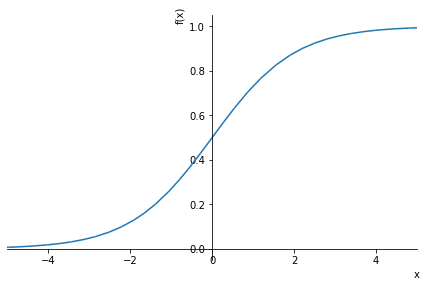

In [51]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5))

In [52]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [53]:
coeffs = train_model(lr=100)

0.524; 0.291; 0.211; 0.203; 0.199; 0.198; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [54]:
acc(coeffs)

tensor(0.8258)

In [55]:
show_coeffs()

{'Age': tensor(-0.4786),
 'SibSp': tensor(-0.0450),
 'Parch': tensor(0.1119),
 'LogFare': tensor(-0.2008),
 'Sex_male': tensor(-10.1734),
 'Sex_female': tensor(7.9806),
 'Pclass_1': tensor(3.3944),
 'Pclass_2': tensor(2.2695),
 'Pclass_3': tensor(-6.1976),
 'Embarked_C': tensor(1.4253),
 'Embarked_Q': tensor(2.1883),
 'Embarked_S': tensor(-5.0948)}

#### Submitting to Kaggle

In [56]:
tst_df = pd.read_csv(path/'test.csv')

In [57]:
tst_df['Fare'] = tst_df.Fare.fillna(0)

In [58]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])

tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

In [59]:
tst_df['Survived'] = (calc_preds(tst_indep, coeffs)>0.5).int()

In [60]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

#### Using matrix product

In [62]:
(val_indep*coeffs).sum(axis=1)

tensor([ 12.4232, -14.1957, -14.9584, -13.0223, -13.0142, -13.0179,   3.1973,   5.1396, -21.4831,   3.1926, -21.4795, -14.9595, -21.4766,
          3.9582, -21.4787, -11.8943, -11.8958,   5.1395, -13.0186,  -3.3258, -21.4789, -11.8951,  12.7754,   5.1356, -21.4781, -14.2018,
         -3.3224, -11.8955, -21.4788,   3.9583,   5.1466,  -3.3303, -21.4785, -21.4794,  12.4228,  -3.3265, -11.8957,  12.7765, -21.4790,
         -3.3257, -13.0127, -21.4790, -13.0122,  12.7754, -21.4787,  -3.3184, -21.4886, -21.4836, -14.1952,  -3.3243,  -4.6187, -21.4837,
        -21.4810, -21.4784, -13.0132, -13.0137, -14.1957, -21.4837, -21.4787, -21.4826,  -5.3733, -21.4785, -11.8975, -21.4787,   5.1343,
        -11.8947, -13.0141, -21.4853, -14.1978,   5.1381, -21.4790,   3.1983, -13.0136, -21.4797, -11.8926, -21.4782, -21.4790, -11.9006,
        -13.0137, -13.0165, -13.0161,  12.7747, -21.4788, -21.4785,   5.1390,  -6.4943,  -5.3800,   6.2599,  11.6560, -13.0140, -21.4797,
        -21.4790,  12.7739, -14.95

In [64]:
# Multiplying elements together and then adding across rows is identical to doing a matrix-vector product!
# Python uses the @ operator to indicate matrix products, and is supported by PyTorch tensors.
# Therefore, we can replicate the above calculate more simply like so:
val_indep@coeffs

tensor([ 12.4232, -14.1957, -14.9584, -13.0223, -13.0142, -13.0179,   3.1973,   5.1396, -21.4831,   3.1926, -21.4795, -14.9595, -21.4766,
          3.9582, -21.4787, -11.8943, -11.8958,   5.1395, -13.0186,  -3.3258, -21.4789, -11.8951,  12.7754,   5.1356, -21.4781, -14.2018,
         -3.3224, -11.8955, -21.4788,   3.9583,   5.1466,  -3.3303, -21.4785, -21.4794,  12.4228,  -3.3265, -11.8957,  12.7765, -21.4790,
         -3.3257, -13.0127, -21.4790, -13.0122,  12.7754, -21.4787,  -3.3184, -21.4886, -21.4836, -14.1952,  -3.3243,  -4.6187, -21.4837,
        -21.4810, -21.4784, -13.0132, -13.0137, -14.1957, -21.4837, -21.4787, -21.4826,  -5.3733, -21.4785, -11.8975, -21.4787,   5.1343,
        -11.8947, -13.0141, -21.4853, -14.1978,   5.1381, -21.4790,   3.1983, -13.0136, -21.4797, -11.8926, -21.4782, -21.4790, -11.9006,
        -13.0137, -13.0165, -13.0161,  12.7747, -21.4788, -21.4785,   5.1390,  -6.4943,  -5.3800,   6.2599,  11.6560, -13.0140, -21.4797,
        -21.4790,  12.7739, -14.95

In [65]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)
